<h1>5. Einblick in andere Zeitreihenmodelle</h1>
<h4>Session 5 (Mittwoch 09:15 – 10:45)</h4>
<br>
5.1 Frequenzanalyse (Fourieranalyse) / Zustandsraumdarstellung (State-space models, Kalman-Filter): Ansatz, Pakete<br>
5.2 Praxisbeispiel additives Regressionsmodell mit Facebook Prophet<br>
5.3 Bsp: Stromverbrauch vorhersagen unter Berücksichtigung von Saisonalität, Wochen- und Feiertagen<br>

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft
from scipy.fft import ifft
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error,mean_squared_error

<h3>5.1 Frequenzanalyse (Fourieranalyse) von Zeitreihendaten</h3>

In [33]:
# Frequenzen, Amplituden, Abtastrate und Zeitbereich festlegen:
f1 =  2  # Frequency 1 in Hz
f2 = 10  # Frequency 2 in Hz
A1 = 6   # Amplitude 1
A2 = 2   # Amplitude 2
Fs = 100 # Sampling rate
t  = np.arange(0,1,1/Fs)

# Primzahlsignale berechnen:
A_sin = A1 * np.sin(2 * np.pi * f1 * t)
A_cos = A2 * np.cos(2 * np.pi * f2 * t)
A_signal = A_sin + A_cos

# etwas Rauschen hinzufügen:
np.random.seed(1)
A_Noise = 2
Noise = np.random.randn(len(t)) * A_Noise
A_signal_noisy = A_signal + Noise

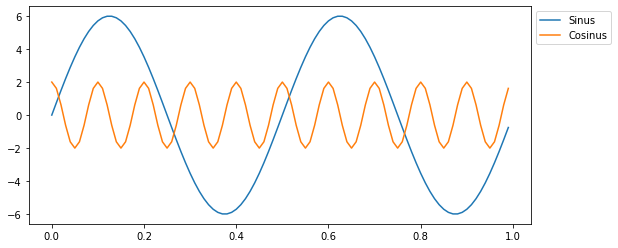

In [34]:
fig=plt.figure(3, figsize=(9,4))
plt.plot(t, A_sin, label="Sinus")
plt.plot(t, A_cos, label="Cosinus")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

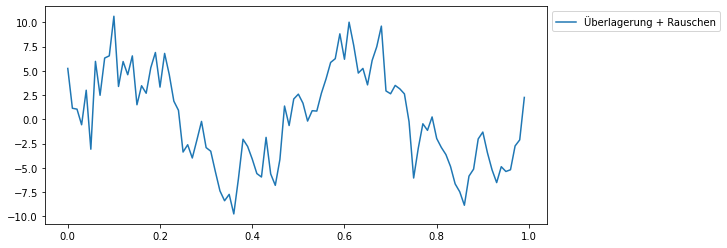

In [35]:
fig=plt.figure(3, figsize=(9,4))
#plt.plot(t, A_signal, label="Überlagerung")
plt.plot(t, A_signal_noisy, label="Überlagerung + Rauschen")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

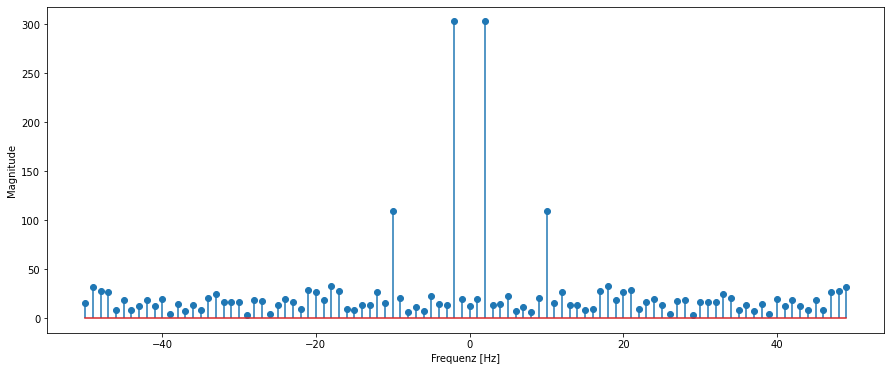

In [9]:
A_signal_fft = scipy.fft.fft(A_signal_noisy)
freq = scipy.fft.fftfreq(np.size(t), 1/Fs)

fig=plt.figure(2, figsize=(15,6))
plt.stem(freq, np.abs(A_signal_fft))
plt.xlabel("Frequenz [Hz]")
plt.ylabel("Magnitude");

In [31]:
threshold = 50  # Replace with your desired threshold
filter_mask = np.abs(A_signal_fft) > threshold

filtered_fft = A_signal_fft * filter_mask

filtered_signal = scipy.fft.ifft(filtered_fft)

filtered_signal_real = np.real(filtered_signal)

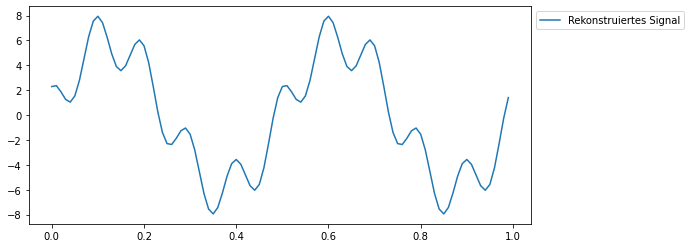

In [36]:
fig=plt.figure(3, figsize=(9,4))
plt.plot(t, filtered_signal_real, label="Rekonstruiertes Signal")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

<div class="alert alert-info">
- Erzeuge ein anderes Signal (durch Veränderung der Frequenzen, Amplituden, Abtastrate)<br>
- Wie verändert sich dein Plot der Überlagerung mit jeweiligen obigen Änderungen?<br>
- Führe eine FFT durch und plotte das Ergebnis wie oben<br>
- Wie verändert sich dein FFT Plot mit jeweiligen obigen Änderungen (Frequenzen, Amplituden, Abtastrate)?
</div>

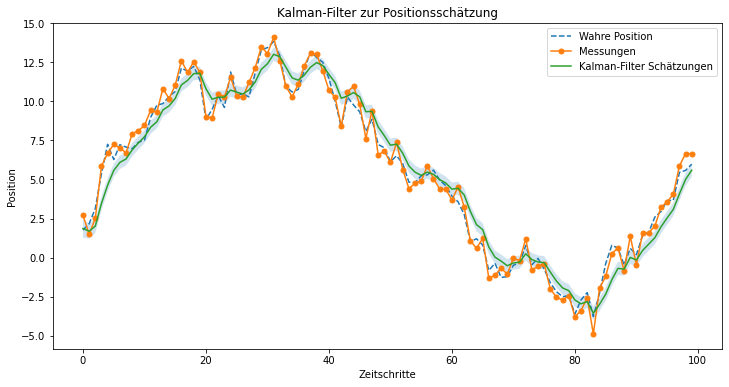

In [37]:
# Simulierte Daten: Wahrer Zustand (Position) eines bewegten Objekts
np.random.seed(0)
n = 100  # Anzahl der Zeitschritte
true_position = np.cumsum(np.random.normal(0, 1, n))

# Simulierte Daten: Messungen mit Rauschen
measurement_noise = 0.5
measurements = true_position + np.random.normal(0, measurement_noise, n)

# Initialisierung des Kalman-Filters
initial_state = 0  # Anfangsschätzung der Position
initial_estimate_error = 1  # Anfangsschätzung der Fehlervarianz

# Kalman-Filter-Parameter
process_noise = 0.1  # Modell für die Unsicherheit im Zustandsübergang
measurement_noise = 0.5  # Unsicherheit in den Messungen

# Listen zur Speicherung der Schätzungen und Fehlervarianzen
estimated_states = []
estimate_errors = []

# Initialisierung
current_state = initial_state
current_estimate_error = initial_estimate_error

# Kalman-Filter-Schleife
for measurement in measurements:
    # Vorhersage
    predicted_state = current_state
    predicted_estimate_error = current_estimate_error + process_noise

    # Korrektur
    kalman_gain = predicted_estimate_error / (predicted_estimate_error + measurement_noise)
    current_state = predicted_state + kalman_gain * (measurement - predicted_state)
    current_estimate_error = (1 - kalman_gain) * predicted_estimate_error

    # Schätzungen speichern
    estimated_states.append(current_state)
    estimate_errors.append(current_estimate_error)

# Plotten der wahren Position, Messungen und Kalman-Filter-Schätzungen
plt.figure(figsize=(12, 6))
plt.plot(true_position, label='Wahre Position', linestyle='--')
plt.plot(measurements, label='Messungen', marker='o', markersize=5)
plt.plot(estimated_states, label='Kalman-Filter Schätzungen')
plt.fill_between(range(n), np.array(estimated_states) - np.sqrt(estimate_errors),
                 np.array(estimated_states) + np.sqrt(estimate_errors), alpha=0.2)
plt.title('Kalman-Filter zur Positionsschätzung')
plt.xlabel('Zeitschritte')
plt.ylabel('Position')
plt.legend()
plt.show()

<h3>5.2 Vorhersagen mit Facebook Prophet</h3>

<h3>Airline Data</h3>

In [38]:
airline = pd.read_csv('AirPassengers.csv')
airline.columns = ['ds','y']
airline['ds'] = pd.to_datetime(airline['ds'])
airline['ds'].freq = 'MS'
airline.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [39]:
airline.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


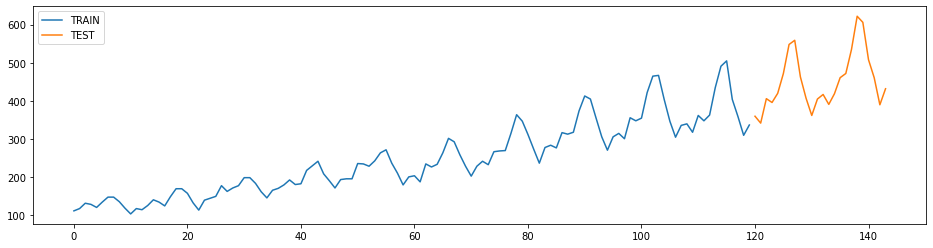

In [40]:
train_airline = airline[:120]
test_airline = airline[120:]
train_airline['y'].plot(legend=True,label='TRAIN')
test_airline['y'].plot(legend=True,label='TEST',figsize=(16,4));

In [144]:
model_air = Prophet()

In [145]:
model_air.fit(train_airline)

23:34:56 - cmdstanpy - INFO - Chain [1] start processing
23:34:56 - cmdstanpy - INFO - Chain [1] done processing


In [146]:
future_air = model_air.make_future_dataframe(periods=24, freq = 'MS')

In [147]:
forecast_prophet = model_air.predict(future_air)
forecast_prophet.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
139,1960-08-01,466.422364,497.992401,545.837008,465.153329,467.667279,55.659317,55.659317,55.659317,55.659317,55.659317,55.659317,0.0,0.0,0.0,522.081681
140,1960-09-01,469.409798,457.930781,505.665220,468.056939,470.733371,13.005285,13.005285,13.005285,13.005285,13.005285,13.005285,0.0,0.0,0.0,482.415083
141,1960-10-01,472.300862,426.805214,472.261806,470.855738,473.699651,-22.202009,-22.202009,-22.202009,-22.202009,-22.202009,-22.202009,0.0,0.0,0.0,450.098854
142,1960-11-01,475.288296,398.214334,445.530526,473.710886,476.790243,-53.341934,-53.341934,-53.341934,-53.341934,-53.341934,-53.341934,0.0,0.0,0.0,421.946362
143,1960-12-01,478.179361,423.362073,472.173396,476.491732,479.784245,-29.977167,-29.977167,-29.977167,-29.977167,-29.977167,-29.977167,0.0,0.0,0.0,448.202193


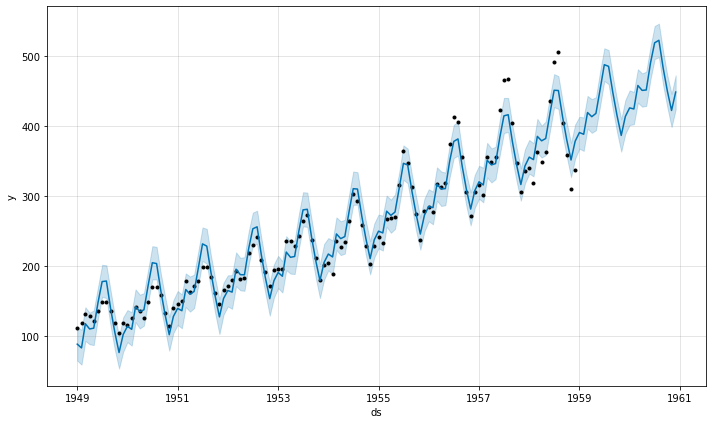

In [148]:
model_air.plot(forecast_prophet);

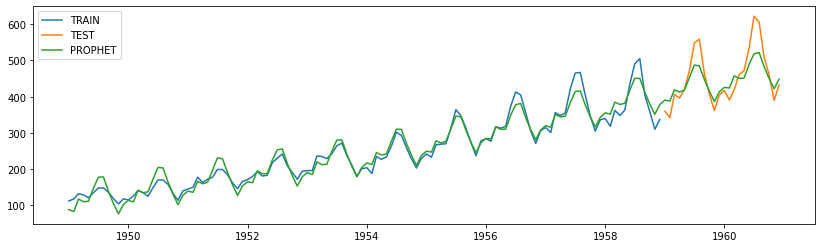

In [149]:
fig = plt.figure(figsize = (14,4))
ax = fig.add_subplot(111)

ax.plot(train_airline['ds'], train_airline['y'], label = 'TRAIN')
ax.plot(test_airline['ds'], test_airline['y'], label = 'TEST')
ax.plot(pred_air['ds'], forecast_prophet['yhat'], label = 'PROPHET')
plt.legend(loc='upper left');
plt.show()

<div class="alert alert-info">
1. Airline-Daten <br>
- Wie performt das Prophetmodell im Vergleich zu Holt-Winter und SARIMA? <br>
- Wiederhole Exponential-Smoothing und ARIMA von gestern und nutze jeweils das passendste Modell für die Vorhersage in den Airlinedaten <br>
- Plotte die drei Vorhersagen in einem Graph. <br>
- Vergleiche die Fehlermaße in einer Tabelle. <br>
2. Stromverbrauchsdaten <br>
- Wir sind gespannt: Wie schneidet Prophet bei unseren Stromverbrauchsdaten im Mai 2012 ab?<br>
- Nutze das Prophetmodell analog zum obigen Beispiel für eine Vorhersage<br>
- Plotte die Ergebnisse - wie sieht Vorhersage für dich aus?<br>
- Überprüfe anhand der bekannten Fehlermaße, wie Prophet im Vergleich zu unserem SARIMA-Modell abschneidet
</div>

In [120]:
# Holt-Winters Triple Exponential Smoothing
model_hw = ExponentialSmoothing(train_airline['y'], trend='add', seasonal='mul', seasonal_periods=12)
model_hw_fit = model_hw.fit()
forecast_hw = model_hw_fit.forecast(len(test_airline))

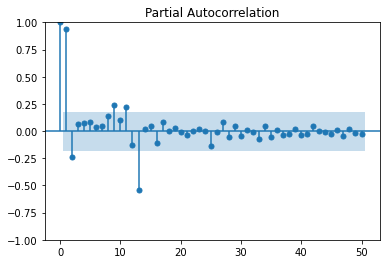

In [121]:
plot_pacf(train_airline['y'], lags=50);

In [122]:
# SARIMA
model_sarima = SARIMAX(train_airline['y'], order=(2, 1, 0), seasonal_order=(1, 2, 1, 12))
model_sarima_fit = model_sarima.fit(disp=False)
forecast_sarima = model_sarima_fit.get_forecast(steps=len(test_airline)).predicted_mean

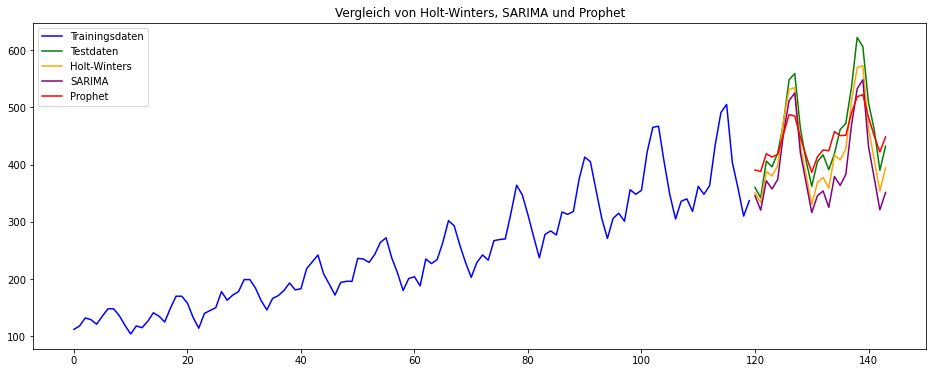

In [123]:
plt.figure(figsize=(16, 6))
plt.plot(train_airline['y'], label='Trainingsdaten', color='blue')
plt.plot(test_airline['y'], label='Testdaten', color='green')
plt.plot(test_airline.index, forecast_hw, label='Holt-Winters', color='orange')
plt.plot(test_airline.index, forecast_sarima, label='SARIMA', color='purple')
plt.plot(test_airline.index, forecast_prophet['yhat'].tail(len(test_airline)), label='Prophet', color='red')
plt.legend(loc='upper left')
plt.title('Vergleich von Holt-Winters, SARIMA und Prophet')
plt.show()

In [124]:
y_true = test_airline['y']
y_hw = forecast_hw
y_sarima = forecast_sarima
y_prophet = forecast_prophet['yhat'].tail(len(test_airline))

mae_hw = mean_absolute_error(y_true, y_hw)
mse_hw = mean_squared_error(y_true, y_hw)

mae_sarima = mean_absolute_error(y_true, y_sarima)
mse_sarima = mean_squared_error(y_true, y_sarima)

mae_prophet = mean_absolute_error(y_true, y_prophet)
mse_prophet = mean_squared_error(y_true, y_prophet)

errors = pd.DataFrame({
    'Art des Fehlers': ['Mean Absolute Error', 'Mean Squared Error'],
    'Holt-Winters Vorhersage': [mae_hw, mse_hw],
    'SARIMA Vorhersage': [mae_sarima, mse_sarima],
    'Prophet Vorhersage': [mae_prophet, mse_prophet]
})

errors.set_index('Art des Fehlers', inplace=True)
errors = round(errors, 2)
errors

,Holt-Winters Vorhersage,SARIMA Vorhersage,Prophet Vorhersage
Art des Fehlers,,,
Mean Absolute Error,28.98,54.71,31.17
Mean Squared Error,1055.48,3535.52,1628.18


In [125]:
em = pd.read_csv("em_HH8_2012_05.csv", index_col=0)
em['Zeit'] = pd.to_datetime(em['Zeit'])
em.set_index('Zeit', inplace=True)
em.index.freq = 'H'
em.head()

,Strom
Zeit,
2012-05-01 00:00:00,834.0
2012-05-01 01:00:00,824.0
2012-05-01 02:00:00,681.0
2012-05-01 03:00:00,530.0
2012-05-01 04:00:00,672.0


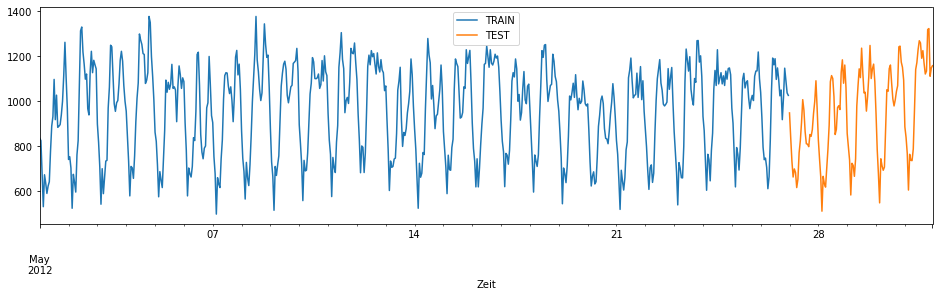

In [126]:
train_em = em[:624]
test_em = em[624:]
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4));

In [128]:
model_hw = ExponentialSmoothing(train_em['Strom'], seasonal='add', seasonal_periods=24)
model_hw_fit = model_hw.fit()
forecast_hw = model_hw_fit.forecast(len(test_em))

In [129]:
model_sarima = SARIMAX(train_em['Strom'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
model_sarima_fit = model_sarima.fit(disp=False)
forecast_sarima = model_sarima_fit.get_forecast(steps=len(test_em)).predicted_mean

In [133]:
df_prophet = train_em.reset_index()
df_prophet.head()

,Zeit,Strom
0,2012-05-01 00:00:00,834.0
1,2012-05-01 01:00:00,824.0
2,2012-05-01 02:00:00,681.0
3,2012-05-01 03:00:00,530.0
4,2012-05-01 04:00:00,672.0


In [139]:
df_prophet = train_em.reset_index()
df_prophet = df_prophet.rename(columns={'Zeit': 'ds', 'Strom': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=len(test_em), freq='H')
forecast_prophet = model_prophet.predict(future)

23:28:19 - cmdstanpy - INFO - Chain [1] start processing
23:28:19 - cmdstanpy - INFO - Chain [1] done processing


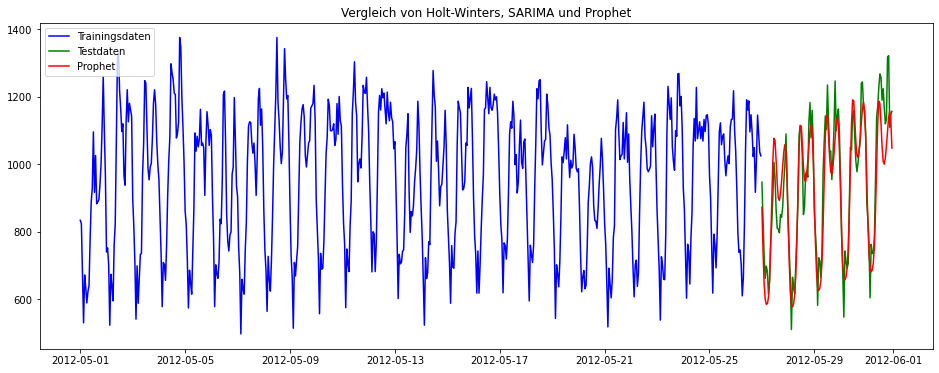

In [140]:
plt.figure(figsize=(16, 6))
plt.plot(train_em['Strom'], label='Trainingsdaten', color='blue')
plt.plot(test_em['Strom'], label='Testdaten', color='green')
plt.plot(test_em.index, forecast_prophet['yhat'].tail(len(test_em)), label='Prophet', color='red')
plt.legend(loc='upper left')
plt.title('Vergleich von Holt-Winters, SARIMA und Prophet')
plt.show()

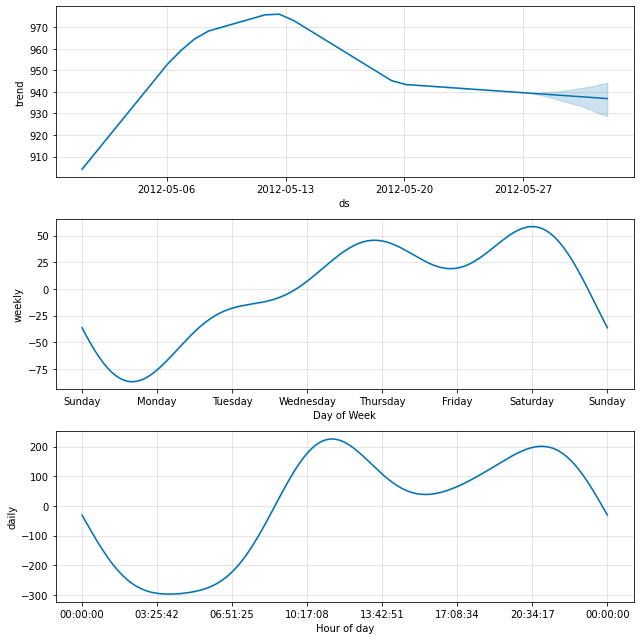

In [141]:
model_prophet.plot_components(forecast_prophet);

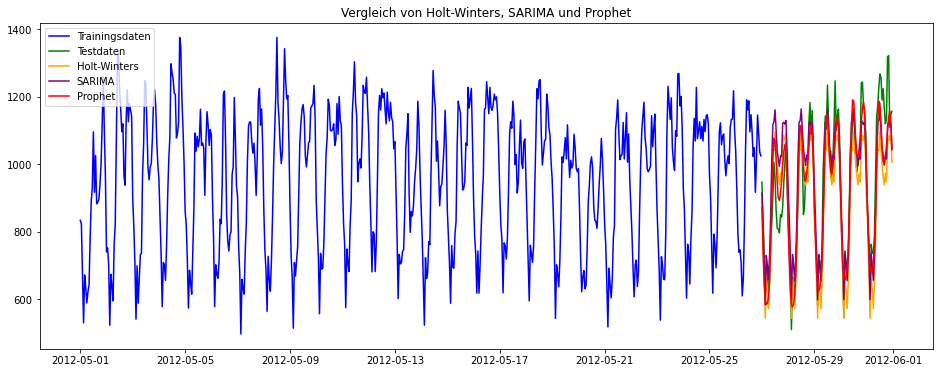

In [142]:
plt.figure(figsize=(16, 6))
plt.plot(train_em['Strom'], label='Trainingsdaten', color='blue')
plt.plot(test_em['Strom'], label='Testdaten', color='green')
plt.plot(test_em.index, forecast_hw, label='Holt-Winters', color='orange')
plt.plot(test_em.index, forecast_sarima, label='SARIMA', color='purple')
plt.plot(test_em.index, forecast_prophet['yhat'].tail(len(test_em)), label='Prophet', color='red')
plt.legend(loc='upper left')
plt.title('Vergleich von Holt-Winters, SARIMA und Prophet')
plt.show()

In [143]:
y_true = test_em['Strom']
y_hw = forecast_hw
y_sarima = forecast_sarima
y_prophet = forecast_prophet['yhat'].tail(len(test_em))

mae_hw = mean_absolute_error(y_true, y_hw)
mse_hw = mean_squared_error(y_true, y_hw)

mae_sarima = mean_absolute_error(y_true, y_sarima)
mse_sarima = mean_squared_error(y_true, y_sarima)

mae_prophet = mean_absolute_error(y_true, y_prophet)
mse_prophet = mean_squared_error(y_true, y_prophet)

errors = pd.DataFrame({
    'Art des Fehlers': ['Mean Absolute Error', 'Mean Squared Error'],
    'Holt-Winters Vorhersage': [mae_hw, mse_hw],
    'SARIMA Vorhersage': [mae_sarima, mse_sarima],
    'Prophet Vorhersage': [mae_prophet, mse_prophet]
})

errors.set_index('Art des Fehlers', inplace=True)
errors = round(errors, 2)
errors

,Holt-Winters Vorhersage,SARIMA Vorhersage,Prophet Vorhersage
Art des Fehlers,,,
Mean Absolute Error,86.89,72.41,63.08
Mean Squared Error,11569.63,9183.88,6181.03
